In [1]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import *
from qiskit.providers.aer.noise.errors import *

from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

import qiskit
from qiskit import QuantumRegister, QuantumCircuit, Aer
from qiskit.quantum_info import state_fidelity, process_fidelity
from qiskit.tools.qi.qi import outer

import time
import math


In [2]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 2
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit

circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.x(qr[0])
circ.z(qr[0])

circ.measure(qr, cr)
print(circ)

         ┌───┐     ┌───┐┌───┐┌─┐
q0_0: |0>┤ H ├──■──┤ X ├┤ Z ├┤M├
         └───┘┌─┴─┐└┬─┬┘└───┘└╥┘
q0_1: |0>─────┤ X ├─┤M├───────╫─
              └───┘ └╥┘       ║ 
 c0_0: 0 ════════════╬════════╩═
                     ║          
 c0_1: 0 ════════════╩══════════
                                


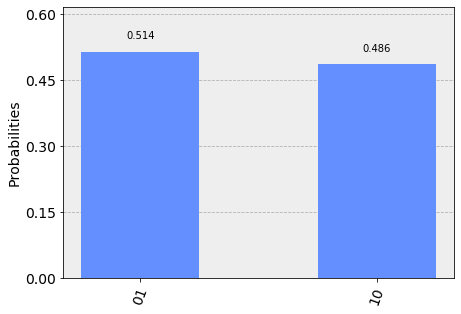

In [3]:
# Ideal execution
job = execute(circ, simulator)
result_ideal = job.result()
plot_histogram(result_ideal.get_counts(0))

This is our ideal singlet state. We should get approxiamtely equal proportions of 10 and 01. 

Now we will create various kinds of errors: Bit-flip, Phase-Flip, Amplitude-Damping, and Thermal Relaxation. 

In [4]:
p_reset = 0.05
p_meas = 0.05
p_gate1 = 0.05

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

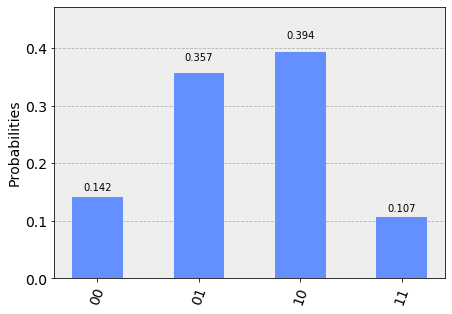

In [5]:
# Run the noisy simulation
job = execute(circ, simulator, basis_gates=noise_bit_flip.basis_gates,
noise_model=noise_bit_flip)
result_bit_flip = job.result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

What we now see is that there are higher amounts of 00 and 11 than p = 0.05, as a bit flip can occur after each gate in the circuit, so the probabilities accumulate and the overall probability of an incorrect result exceeds .05.  

Probability calculation: 

There are five points where a bit-flip can occur due to the design of the singlet-state circuit. Therefore, there is a .95 * .95 * .95 * .95 * .95 of having no bit flips at all. 

Thus, there is an approximately 77% chance that there is no bit-flip. That means that the proportions for the correct measurements of 01 and 10 should be around 0.38 for both. The probability that multiple bit-flips occur and still give the right result of 01 and 10 is insignificant, as that probability has at least two 0.05 values in the product (causing the value to be very small). This 77% chance of no bit-flip matches our histogram, as both 01 and 10 have approximately a 38% chance of occurring.  

In [6]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 2
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit

circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.x(qr[0])
circ.z(qr[0])

circ.measure(qr, cr)
print(circ)

p_reset = 0.95
p_meas = 0.95
p_gate1 = 0.95

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])


         ┌───┐     ┌───┐┌───┐┌─┐
q1_0: |0>┤ H ├──■──┤ X ├┤ Z ├┤M├
         └───┘┌─┴─┐└┬─┬┘└───┘└╥┘
q1_1: |0>─────┤ X ├─┤M├───────╫─
              └───┘ └╥┘       ║ 
 c1_0: 0 ════════════╬════════╩═
                     ║          
 c1_1: 0 ════════════╩══════════
                                


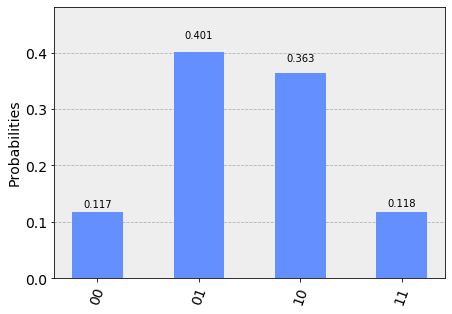

In [7]:
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_bit_flip.basis_gates,
              noise_model=noise_bit_flip)
result_bit_flip = job.result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

Notice that a p = 0.95 creates the same results, due to the symmetricity of the bit-flips. A 95% chance of a bit-flip means that a bit-flip is essentially going to occur every time. However, in the case of the singlet state, if a bit-flip occurs every time that it can possibly occur, the end result is still measured as the correct 01 or 10. As a result, p-values close to 1 and p-values close to 0 result in less significant error. As the p approaches .5 from either end, the noise becomes more damaging.  

Now we will test thermal relaxation. 

In [8]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 2
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit

circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.x(qr[0])
circ.z(qr[0])


circ.measure(qr, cr)
print(circ)
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0 # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 300 # (two X90 pulses)
time_cx = 1000
time_reset = 1000# 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

         ┌───┐     ┌───┐┌───┐┌─┐
q2_0: |0>┤ H ├──■──┤ X ├┤ Z ├┤M├
         └───┘┌─┴─┐└┬─┬┘└───┘└╥┘
q2_1: |0>─────┤ X ├─┤M├───────╫─
              └───┘ └╥┘       ║ 
 c2_0: 0 ════════════╬════════╩═
                     ║          
 c2_1: 0 ════════════╩══════════
                                
NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['reset', 'cx', 'measure', 'u3', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


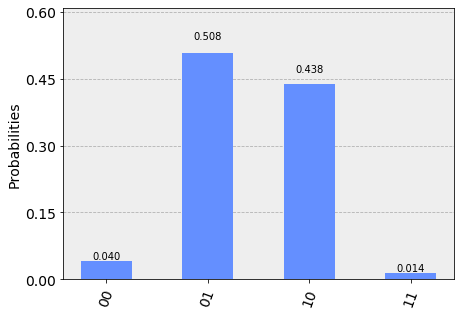

In [9]:
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

In [10]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 2
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit

circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.x(qr[0])
circ.z(qr[0])

circ.ry(math.pi/2, qr)

circ.measure(qr, cr)
print(circ)
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0 # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 300 # (two X90 pulses)
time_cx = 1000
time_reset = 1000 # 1 microsecond
time_measure =  1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

         ┌───┐         ┌───┐     ┌───┐┌────────────┐┌─┐
q3_0: |0>┤ H ├──■──────┤ X ├─────┤ Z ├┤ Ry(1.5708) ├┤M├
         └───┘┌─┴─┐┌───┴───┴────┐└┬─┬┘└────────────┘└╥┘
q3_1: |0>─────┤ X ├┤ Ry(1.5708) ├─┤M├────────────────╫─
              └───┘└────────────┘ └╥┘                ║ 
 c3_0: 0 ══════════════════════════╬═════════════════╩═
                                   ║                   
 c3_1: 0 ══════════════════════════╩═══════════════════
                                                       
NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['reset', 'cx', 'measure', 'u3', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0])

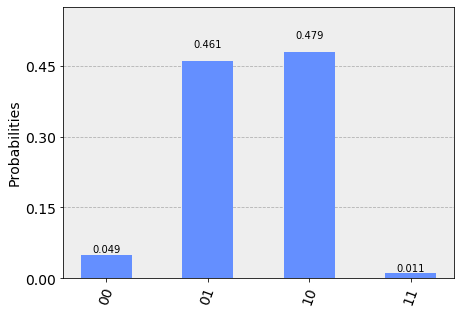

In [11]:
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

In [12]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 2
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit

circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.x(qr[0])
circ.z(qr[0])

circ.measure(qr, cr)
print(circ)
# Create an empty noise model
noise_modelAmplitude = NoiseModel()

# Add amplitude error to all single qubit u1, u2, u3 gates
ampDamp = amplitude_damping_error(.05, 0, True)
noise_modelAmplitude.add_all_qubit_quantum_error(ampDamp, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_modelAmplitude)

         ┌───┐     ┌───┐┌───┐┌─┐
q4_0: |0>┤ H ├──■──┤ X ├┤ Z ├┤M├
         └───┘┌─┴─┐└┬─┬┘└───┘└╥┘
q4_1: |0>─────┤ X ├─┤M├───────╫─
              └───┘ └╥┘       ║ 
 c4_0: 0 ════════════╬════════╩═
                     ║          
 c4_1: 0 ════════════╩══════════
                                
NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


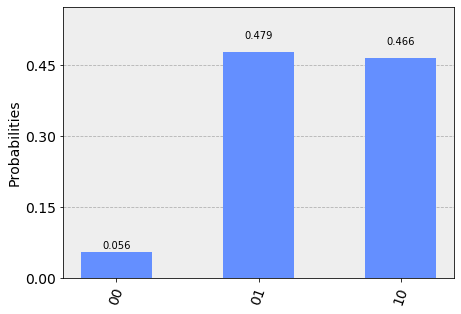

In [13]:
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_modelAmplitude.basis_gates,
              noise_model=noise_modelAmplitude)
result_amplitudeDamp = job.result()
counts_amplitudeDamp = result_amplitudeDamp.get_counts(0)

# Plot noisy output
plot_histogram(counts_amplitudeDamp)

As expected, no 11 states, as amplitude damping channels cause longitudinal relaxation (1 to 0). A small percent of 00 states were measured, equal to p. This probability increases as p increases. So the probability of 00 is essentially p (whether p is .95, .5, or .05), and the other results are evenly distributed between 10 and 01. This is unlike the bit-flip, because as the p increases and gets closer to 1, the erroneous measurement of 00 has a higher and higher proportion too. 

         ┌───┐     ┌───┐┌───┐┌─┐
q5_0: |0>┤ H ├──■──┤ X ├┤ Z ├┤M├
         └───┘┌─┴─┐└┬─┬┘└───┘└╥┘
q5_1: |0>─────┤ X ├─┤M├───────╫─
              └───┘ └╥┘       ║ 
 c5_0: 0 ════════════╬════════╩═
                     ║          
 c5_1: 0 ════════════╩══════════
                                


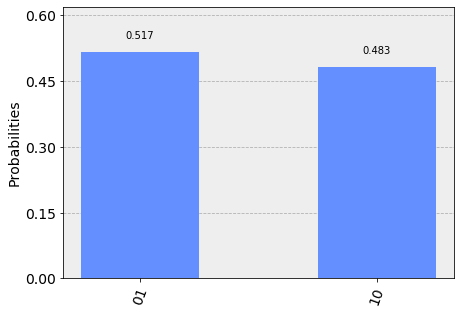

In [14]:
#Phase 
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 2
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit

circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.x(qr[0])
circ.z(qr[0])

circ.measure(qr, cr)
print(circ)


p_meas = 0.05
p_gate1 = 0.05

error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_phase_flip = NoiseModel()
noise_phase_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_phase_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_phase_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_phase_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])


# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_phase_flip.basis_gates,
              noise_model=noise_phase_flip)
result_phase_flip = job.result()
counts_phase_flip = result_phase_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_phase_flip)




As expected, a phase flip has no effect on the measurements made. It simply changes the azimuthal position of the qubit, meaning that longitudally it stays at its original 1 or 0. Now, if we want to test to see if this error has created the triplet 0 state due to the phase flip, all we have to do is use the previous distinguishing test and rotate both qubits about the y-axis (or x-axis) by 90 degrees as follows. 

         ┌───┐         ┌───┐     ┌───┐┌────────────┐┌─┐
q6_0: |0>┤ H ├──■──────┤ X ├─────┤ Z ├┤ Ry(1.5708) ├┤M├
         └───┘┌─┴─┐┌───┴───┴────┐└┬─┬┘└────────────┘└╥┘
q6_1: |0>─────┤ X ├┤ Ry(1.5708) ├─┤M├────────────────╫─
              └───┘└────────────┘ └╥┘                ║ 
 c6_0: 0 ══════════════════════════╬═════════════════╩═
                                   ║                   
 c6_1: 0 ══════════════════════════╩═══════════════════
                                                       


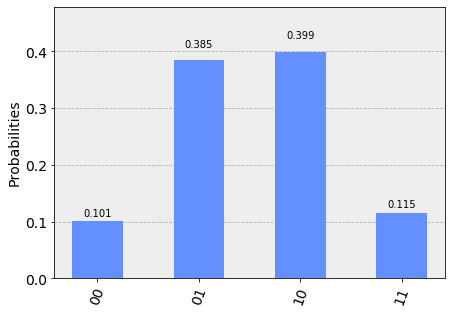

In [15]:
#Phase and experiment with Triplet 0 Rotation measurements 
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 2
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.x(qr[0])
circ.z(qr[0])

circ.ry(math.pi/2, qr)

circ.measure(qr, cr)
print(circ)

p_reset = 0.05
p_meas = 0.05
p_gate1 = 0.05

error_reset = pauli_error([('Z', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_phase_flip = NoiseModel()
noise_phase_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_phase_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_phase_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_phase_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])


# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_phase_flip.basis_gates,
              noise_model=noise_phase_flip)
result_phase_flip = job.result()
counts_phase_flip = result_phase_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_phase_flip)

As one can see, the phase flip causes some error. Some qubits end up becoming the triplet 0 state expected measurement after the rotation. After all, a rotation about the y-axis allows us to measure the x-components, which should be 00 or 11 for a triplet 0 state and remain at 10 and 01 for a singlet state. The concept of how the compounding of flips in a large number of gates increases the probability of incorrect measurements once again appears here. 

Test with State Tomography: 

In [16]:
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
bell.x(q2[0])
bell.z(q2[0])
print(bell)

job = qiskit.execute(bell, Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(bell)
print(psi_bell)

         ┌───┐     ┌───┐┌───┐
q7_0: |0>┤ H ├──■──┤ X ├┤ Z ├
         └───┘┌─┴─┐└───┘└───┘
q7_1: |0>─────┤ X ├──────────
              └───┘          
[ 0.        +0.j -0.70710678+0.j  0.70710678+0.j  0.        +0.j]


In [17]:
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
bell.x(q2[0])
bell.z(q2[0])
print(bell)

         ┌───┐     ┌───┐┌───┐
q8_0: |0>┤ H ├──■──┤ X ├┤ Z ├
         └───┘┌─┴─┐└───┘└───┘
q8_1: |0>─────┤ X ├──────────
              └───┘          


In [18]:
# Generate circuits and run on simulator
t = time.time()
# Generate the state tomography circuits. 
p_reset = 0.05
p_meas = 0.05
p_gate1 = 0.5

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

qst_bell = state_tomography_circuits(bell, [q2[0],q2[1]])     

# Plot noisy output

job2 = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000, noise_model =  noise_bit_flip)                          
print('Time taken:', time.time() - t)

tomo_bell = StateTomographyFitter(job2.result(), qst_bell)

Time taken: 0.08377504348754883


In [19]:
# Perform the tomography fit
# which outputs a density matrix
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity =', F_bell)
print(rho_bell)
print(tomo_bell)

Fit Fidelity = 0.44949394778069396
[[ 0.25509719+0.j         -0.00515555-0.00041207j  0.00502858+0.00204017j
  -0.20144635-0.00178695j]
 [-0.00515555+0.00041207j  0.24803098+0.j         -0.20373219-0.00399087j
  -0.00447275+0.00383958j]
 [ 0.00502858-0.00204017j -0.20373219+0.00399087j  0.24349253+0.j
   0.00898529+0.00101001j]
 [-0.20144635+0.00178695j -0.00447275-0.00383958j  0.00898529-0.00101001j
   0.25337929+0.j        ]]


As expected, fit fidelity drops from 0.99 to 0.45 in the presence of noise. 


In summary: 

Bit-flip probabilities accumulate.  The bit-flip does the most damage to the singlet state due to the compounding of probabilities. 

Phase-flip produces inaccuracies when the y and x components are measured rather than the z due to the switch from the singlet state to the triplet 0 state. However, measuring the z-components, the noise has little to no effect at all. 

Thermal relaxation probability of 11 is negligible, and as for 00, it depends on the magnitude of the Time with regards to the entered T1. Higher times lead to higher amounts of 00. 

Amplitude Damping probability of 00 is equal to the entered probability, unlike bit-flip. At low values of p like p = 0.05, then, amplitude damping is less damaging than bit-flip.  

Suggested Method to Quantify Accuracy: 

1 - (|P(11) + P(00)| + 0.5|P(10) - P(01)|) 

The closer to one this index gets, the worse. A perfect singlet state has index 1. An even distribution would have index 0.5. A completely opposite distribution (only 00 and 11) would have index 0. Similarly, the state of only 10 would have index 0.5, which is also bad. The 0.5 coefficient in the second term is to assign a higher weight to 11 and 00 states, which are completely wrong.

This index can also take into account phase, expanding as follows: 

1 - (|P(11) + P(00)| + 0.5|P(10) - P(01)| + 0.5|P(11) after y-axis rotation by 90 degrees + P(00) after y-axis rotaton by 90 degrees|)
